In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

## Extract

In [3]:
load_dotenv()

True

In [4]:
URL = 'https://www.alphavantage.co/query'
API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")

In [5]:
def fetch_data(symbol):
    params = {
        'function': 'TIME_SERIES_WEEKLY',
        'symbol': symbol,
        'apikey': API_KEY        
    }
    response = requests.get(URL, params=params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f'Error! Status code: {response.status_code}')
        return None

In [6]:
stock_data = fetch_data('IBM')

## Transform

In [8]:
def parse_series(data):
    time_series_key = "Weekly Time Series"
    if time_series_key in data:
        df = pd.DataFrame.from_dict(data[time_series_key], orient = 'index')
        df = df.rename(columns = lambda x: x.split(' ')[1])
        df.index = pd.to_datetime(df.index)
        df = df.astype(float)
        return df.sort_index()
    else:
        print("Error!")
        return None

In [9]:
weekly_stock_df = parse_series(stock_data)

In [10]:
weekly_stock_df.head()

,open,high,low,close,volume
1999-11-12,90.50,97.50,90.50,95.87,43569700.0
1999-11-19,96.00,105.12,92.62,103.94,61550800.0
1999-11-26,105.50,109.87,101.81,105.00,37165600.0
1999-12-03,104.94,112.87,102.12,111.87,37670000.0
1999-12-10,113.00,122.12,107.56,109.00,58626000.0


In [11]:
print(weekly_stock_df.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [12]:
print(weekly_stock_df.dtypes)

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


In [13]:
print(weekly_stock_df.duplicated().sum())

0


In [14]:
print(weekly_stock_df.describe())

              open         high          low        close        volume
count  1319.000000  1319.000000  1319.000000  1319.000000  1.319000e+03
mean    132.745703   135.799157   129.932843   132.932270  2.833523e+07
std      37.612317    38.044101    37.301415    37.776034  1.309048e+07
min      56.600000    62.000000    54.010000    56.600000  7.770697e+06
25%     101.410000   106.085000    98.690000   102.080000  1.868110e+07
50%     129.390000   132.100000   126.850000   129.260000  2.517370e+07
75%     158.510000   161.855000   154.625000   158.940000  3.468358e+07
max     252.400000   265.720000   251.840000   261.280000  1.108978e+08


In [15]:
weekly_stock_df = weekly_stock_df.round(2)

In [16]:
weekly_stock_df.reset_index(inplace=True)

In [17]:
weekly_stock_df.rename(columns={'index': 'date'}, inplace=True)

In [45]:
weekly_stock_df.head()

,date,open,high,low,close,volume
0,1999-11-12,90.50,97.50,90.50,95.87,43569700.0
1,1999-11-19,96.00,105.12,92.62,103.94,61550800.0
2,1999-11-26,105.50,109.87,101.81,105.00,37165600.0
3,1999-12-03,104.94,112.87,102.12,111.87,37670000.0
4,1999-12-10,113.00,122.12,107.56,109.00,58626000.0


## Visualizations

<Axes: ylabel='close'>

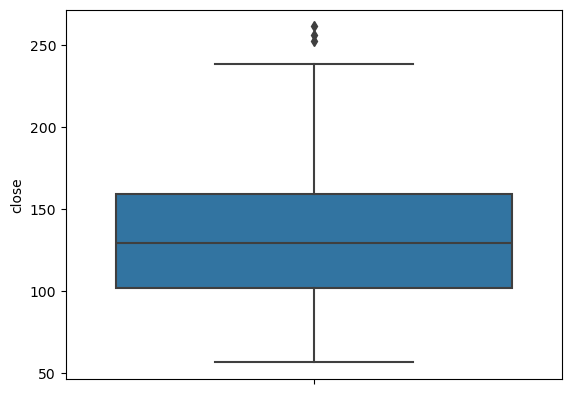

In [19]:
sns.boxplot(y = weekly_stock_df['close'])

Text(0, 0.5, 'Frequency')

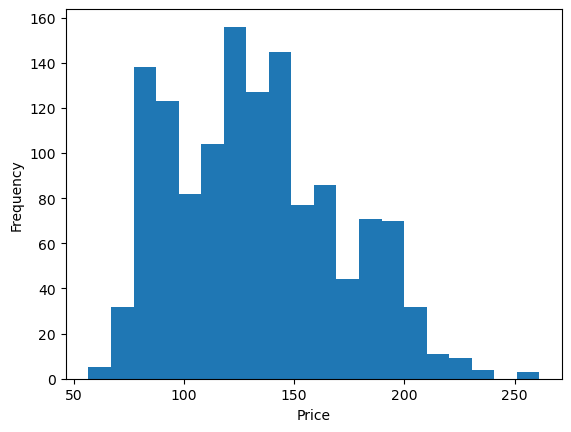

In [20]:
plt.hist(weekly_stock_df['close'], bins=20)
plt.xlabel('Price')
plt.ylabel('Frequency')

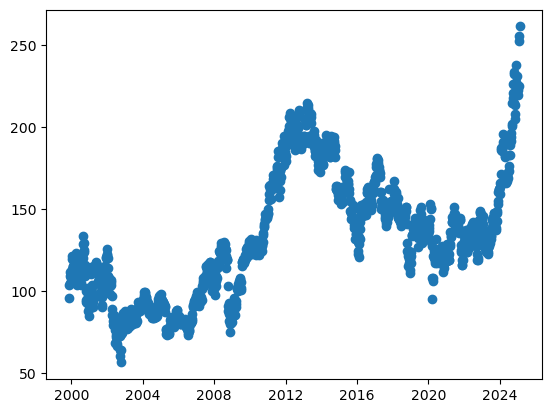

In [21]:
plt.scatter(weekly_stock_df['date'], weekly_stock_df['close'])

## Exporting to database

In [23]:
connection_string = os.getenv("DB_CONNECTION_STRING")
engine = create_engine(connection_string)

In [24]:
table_name = 'weekly_stock_data'
weekly_stock_df.to_sql(
    name=table_name,
    con=engine,
    if_exists="replace",
    index=False
)

319